In [1]:
#Install Packages
!pip install wordcloud

#Import Libraries
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import json,os,uuid
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [244]:
def get_reviews(id, number_of_reviews = 200):
    review_, _ = reviews(
        id,
        lang='id', # defaults to 'en'
        country='id', # defaults to 'us'
        sort=Sort.NEWEST, # defaults to Sort.NEWEST
        count=number_of_reviews
    )
    
    review_ = pd.DataFrame(review_)
    review_ = review_[[
        'content',
        'score'
    ]]
    
    return review_

In [2]:
# mobilelegends_reviews = get_reviews(id='com.mobile.legends', number_of_reviews=10000)
mobilelegends_reviews = pd.read_csv("mobilelegends_reviews_countryid.csv")

In [239]:
# mobilelegends_reviews.sample(5)

In [248]:
# Storing Data
# mobilelegends_reviews.to_csv('mobilelegends_reviews_countryid.csv',index=False)

In [4]:
mobilelegends_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  10000 non-null  object
 1   score    10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [5]:
mobilelegends_reviews.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
content,10000,7308,Mantap,342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,10000.0,NaN,NaN,NaN,3.7128,1.712778,1.0,2.0,5.0,5.0,5.0


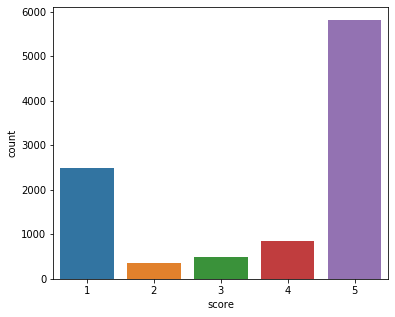

In [6]:
plt.figure(figsize=(6,5))
sns.countplot(data=mobilelegends_reviews, x='score')

In [7]:
# DATA PREPROCESSING

In [8]:
#Drop some columns which we won't use for sentiment analysis of review
data = mobilelegends_reviews.copy()

In [9]:
def data_cleaning(data):
    
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    def space(comment):
        doc = nlp(comment)
        return " ".join([token.lemma_ for token in doc])
    
    # apply lower string
    data['content'] = data['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # remove punctuation
    data['content'] = data['content'].str.replace('[^\w\s]','')
    
    # remove emojis
    data['content'] = data['content'].apply(lambda x: remove_emoji(x))
    
    # remove stopwords
    stop = stopwords.words('indonesian')
    data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    # Lemmatization
    data['content']= data['content'].apply(space)
    
    return data

In [10]:
data = data_cleaning(data)

In [11]:
words_to_remove = ['game','montoon','ml','nya','kalo','moonton','monton','yg','gw','main','gk','aja','gua','gak','tolong','mulu','udah','lu','ga','ya']
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

In [12]:
# sentences = 'i love spicy food. Spicy food not a junk food.'
# temp = nlp(sentences)
# " ".join([token.lemma_ for token in temp])

In [13]:
# Create sentiment data
data['sentiment'] = data['score'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.sample(5)

,content,score,sentiment
5397,good,5,2
8195,bagus,4,2
4815,senang hati,5,2
3630,tolol ngasi tim pake otak lose lose 7 menang 1...,1,0
8384,sistem pemilihan player buruk,1,0


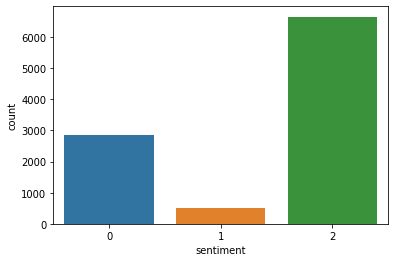

In [34]:
sns.countplot(data=data, x='sentiment')

In [14]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

2    66.57
0    28.51
1     4.92
Name: sentiment, dtype: float64

In [15]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

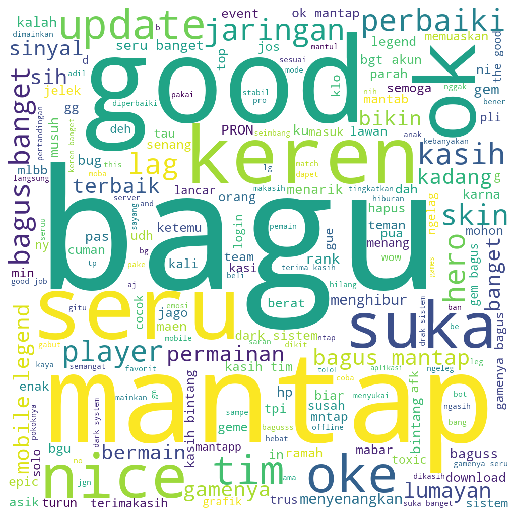

In [17]:
# Positive Setiment
stopword = set(stopwords.words('indonesian'))
text = " ".join(review for review in positive.content)
wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='white',
                stopwords = stopword,
                min_font_size = 10).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('positive_sentiment.png')
plt.show()

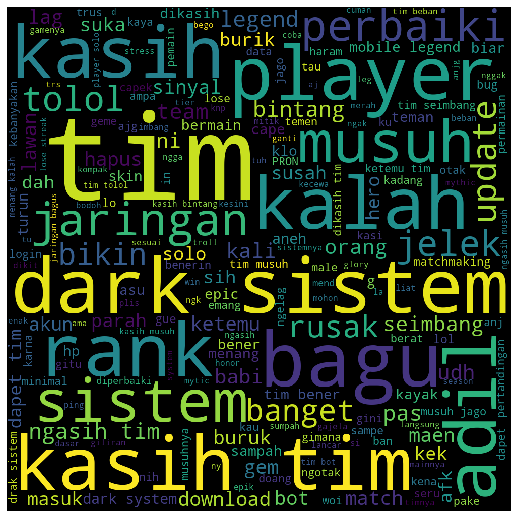

In [18]:
# Negative Setiment
stopword = set(stopwords.words('indonesian'))
text = " ".join(review for review in negative.content)
wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('negative_sentiment.png')
plt.show()

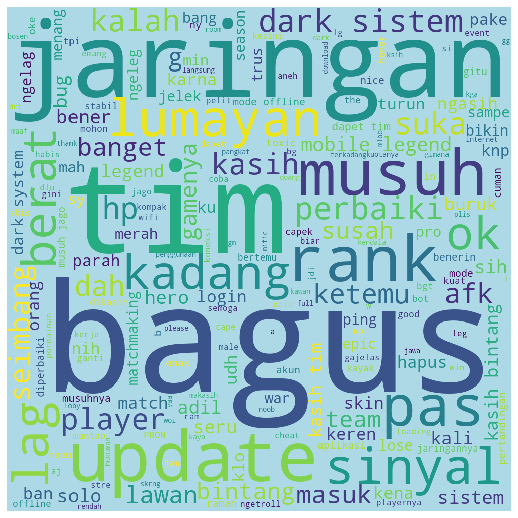

In [19]:
# Neutral Setiment
stopword = set(stopwords.words('indonesian'))
text = " ".join(review for review in neutral.content)
wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='lightblue',
                stopwords = stopword,
                min_font_size = 10).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('neutral_sentiment.png')
plt.show()

In [21]:
# Get the tokenizer patter with contraint a-z, A-Z, 0-9 and more than one character can happen
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [27]:
# Example
token.tokenize("hello@@yeyeyee, my name is ri_sdan")

['hello', 'yeyeyee', 'my', 'name', 'is', 'ri', 'sdan']

In [154]:
# Convert a collection of corpus to a matrix of token counts
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)

X = cv.fit_transform(data['content'])
y = data['sentiment']

In [33]:
len(list(cv.get_feature_names_out()))

8665

There is 8665 tokens

In [35]:
# Because there is large imbalance in the dependet feature, we will use SMOTE
# Instantiate the SMOTE object
smote = SMOTE()

# Perform oversampling
X_oversampled, y_oversampled = smote.fit_resample(X, y)

In [36]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_oversampled,
                                                  y_oversampled,
                                                  test_size=0.15,
                                                  random_state=17,stratify=y_oversampled)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16975, 8665)
(2996, 8665)
(16975,)
(2996,)


In [37]:
# Modeling

In [38]:
# MultinomialNB
#Training the model
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.80      0.52      0.63      1516
           1       0.35      0.47      0.40       752
           2       0.59      0.80      0.68       728

    accuracy                           0.58      2996
   macro avg       0.58      0.60      0.57      2996
weighted avg       0.63      0.58      0.59      2996



In [54]:
# logistic Regression
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print("Logistic Regression Model")
print(classification_report(y_pred, y_test))

Logistic Regression Model
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       764
           1       0.81      0.57      0.67      1411
           2       0.62      0.76      0.68       821

    accuracy                           0.67      2996
   macro avg       0.67      0.70      0.67      2996
weighted avg       0.70      0.67      0.67      2996



In [55]:
# Random Forest
# Initialize and train the random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print("Random Forest Model")
print(classification_report(y_pred, y_test))

Random Forest Model
              precision    recall  f1-score   support

           0       0.61      0.77      0.68       791
           1       0.84      0.58      0.69      1448
           2       0.60      0.80      0.69       757

    accuracy                           0.69      2996
   macro avg       0.69      0.72      0.69      2996
weighted avg       0.72      0.69      0.69      2996



In [57]:
# Xtreme Gradient Boosting
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print("Xtreme Gradient Boostin Model")
print(classification_report(pred_labels, y_test))

Xtreme Gradient Boostin Model
              precision    recall  f1-score   support

           0       0.69      0.86      0.77       804
           1       0.82      0.86      0.84       950
           2       0.89      0.72      0.80      1242

    accuracy                           0.80      2996
   macro avg       0.80      0.81      0.80      2996
weighted avg       0.82      0.80      0.80      2996



In [49]:
dic = {
    'model':['Multinomial NB','Logistic Regression','Random Forest','XGB'],
    'precision':[0.58,0.69,0.68,0.80],
    'recall':[0.60,0.70,0.71,0.81],
    'accuracy':[0.58,0.67,0.68,0.80],
    'f1-score':[0.57,0.67,0.68,0.80]
}

report_recap = pd.DataFrame(dic)
report_recap

,model,precision,recall,accuracy,f1-score
0,Multinomial NB,0.58,0.60,0.58,0.57
1,Logistic Regression,0.69,0.70,0.67,0.67
2,Random Forest,0.68,0.71,0.68,0.68
3,XGB,0.80,0.81,0.80,0.80


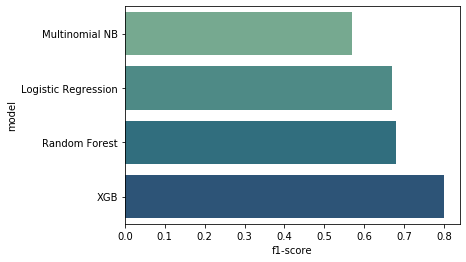

In [67]:
sns.barplot(data=report_recap, y='model', x='f1-score', palette='crest')

In [172]:
model

In [194]:
review = [
    "Dapat tim yang tidak bisa main, kalah terus",
    "Pilihan hero yang banyak dengan skil yang unik, game keren",
    "Game nya susah dimainkan, perlu latihan beberapa kali baru hapal",
    "Dari game ini udah beberapa kali ikut turnamen dan menang dapat hadiah menarik",
    "Keluar hero baru dengan skill yang keren, selalu update"]
transf_rev = xgb.DMatrix(cv.transform(pd.Series(review)))

pd.DataFrame({'review': review,
             'pred_sentiment': list(model.predict(transf_rev))})

,review,pred_sentiment
0,"Dapat tim yang tidak bisa main, kalah terus",0.0
1,Pilihan hero yang banyak dengan skil yang unik...,2.0
2,"Game nya susah dimainkan, perlu latihan bebera...",0.0
3,Dari game ini udah beberapa kali ikut turnamen...,2.0
4,"Keluar hero baru dengan skill yang keren, sela...",2.0
